# Modling By RNN 

data: https://www.kaggle.com/datasets/allanjackson/rossmann


check also the walmart dataset 

In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 9.8 MB 31.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
! pip install statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## importing required libraries 

In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.cbook import boxplot_stats

import time 
import datetime
from datetime import timedelta
from datetime import datetime

import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
# from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.callbacks import  EarlyStopping


In [ ]:
train_data_source ='https://raw.githubusercontent.com/AshrafHabromman/Rossmann_Sales_Forecasting/main/data/train.csv'
train_data_l = r'data\train.csv'
df_train = pd.read_csv(train_data_source, index_col = ['Date'], parse_dates = True,)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_train.head() 

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [ ]:
store_sample = df_train[df_train['Store']==1]
store_sample.sort_index(ascending=True, inplace=True)
store_sample.drop('Store',axis=1, inplace=True)
store_sample.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2013-01-01,2,0,0,0,0,a,1
2013-01-02,3,5530,668,1,0,0,1
2013-01-03,4,4327,578,1,0,0,1
2013-01-04,5,4486,619,1,0,0,1
2013-01-05,6,4997,635,1,0,0,1


In [ ]:
store_sample.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DayOfWeek      942 non-null    int64 
 1   Sales          942 non-null    int64 
 2   Customers      942 non-null    int64 
 3   Open           942 non-null    int64 
 4   Promo          942 non-null    int64 
 5   StateHoliday   942 non-null    object
 6   SchoolHoliday  942 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 58.9+ KB


* Check that the date is continuous 

In [ ]:

store_sample.asfreq('D').isnull().sum() 

DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

* So no any missing values

## Prepare data

In [ ]:
def prepare_data(data, target, start_index, end_index, history_size, target_size):

  start_index = start_index + history_size 
  end_index = end_index - target_size

  history = []
  new_target = []

  for i in range(start_index, end_index): 
    hist_i = data[i-history_size:i]
    targ_i = target[i:i+target_size]

    history.append(hist_i)
    new_target.append(targ_i)

  return np.array(history, dtype=np.float64), np.array(new_target, dtype=np.float64)


## Split data To train and test 

In [ ]:
train_until = datetime(2015,4,30)

In [ ]:
def train_test_split(x, y, train_until):

  x_train = x.loc[:train_until,:]
  x_test = x.loc[train_until+timedelta(days=1):,:]

  y_train = y[:train_until]         
  y_test = y[train_until+timedelta(days=1):]

  return x_train, x_test, y_train, y_test

## Pre-processing Data

In [ ]:
# def do_lags(df, num_lags):
#   return pd.concat(
#       {
#           f'lag_{i}': df.shift(i, fill_value=0)
#           for i in range(1,num_lags+1)
#       },
#       axis=1
#   )


def pre_process_data_rnn(store_data):

  store_data['DayOfWeek'] = store_data.index.dayofweek
  store_data['Week'] = store_data.index.week 
  store_data['month'] = store_data.index.month
  store_data['year'] = store_data.index.year
  store_data['dayofyear'] = store_data.index.dayofyear


  store_pre_processed = pd.DataFrame(index=store_data.index, )

  # store_pre_processed = pd.get_dummies(store_data['DayOfWeek'], prefix='DayOfWeek')

  stat_dums = pd.get_dummies(store_data['StateHoliday'], prefix='StateHoliday').drop('StateHoliday_0', axis='columns')
  store_pre_processed = store_pre_processed.join(stat_dums)

  
  week_before_state_holiday = pd.DataFrame(index=store_data.index)

  for col in stat_dums.columns: 
    state_holiday_ = pd.DataFrame(index=store_data.index,)
    for i in range(-7,0):
      state_holiday_shifted = stat_dums[col].shift(i, fill_value=0)
      state_holiday_shifted = state_holiday_shifted.to_frame()
      state_holiday_shifted.rename(columns={col:f'{col}_shifted_{i}'}, inplace=True)
      state_holiday_ = state_holiday_.join(state_holiday_shifted)

    week_before_state_holiday_ = state_holiday_.sum(axis=1)

    week_before_state_holiday_ = week_before_state_holiday_.to_frame(name=f'week_before_{col}')
    week_before_state_holiday = week_before_state_holiday.join(week_before_state_holiday_,)  

  store_pre_processed = store_pre_processed.join(week_before_state_holiday)

  store_pre_processed = store_pre_processed.join(store_data['SchoolHoliday'])


  store_data['DayOfWeek'] = (store_data['DayOfWeek']+1) % 7 
  data_to_scale = store_data[['DayOfWeek', 'Week',	'month', 'year', 'dayofyear']]
  
  min_max_scaler = MinMaxScaler()
  scaled_data = min_max_scaler.fit_transform(data_to_scale)

  scaled_data = pd.DataFrame(scaled_data, index=data_to_scale.index, columns=data_to_scale.columns )
  store_pre_processed = store_pre_processed.join(scaled_data)  

  store_sales_rolling_std = store_data['Sales'].rolling(window=7, center=False, min_periods=1).std().fillna(0) # set rolling to the right 
  store_sales_rolling_std = store_sales_rolling_std.to_frame()
  store_sales_rolling_std.rename(columns={'Sales':'Sales_std'}, inplace=True)
  
  store_sales_rolling_mean = store_data['Sales'].rolling(window=7, center=False, min_periods=1).mean().fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.to_frame()
  store_sales_rolling_mean.rename(columns={'Sales':'Sales_mean'}, inplace=True)

  store_sales_rolling_std = store_sales_rolling_std.shift(1).fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.shift(1).fillna(0)

  store_pre_processed = store_pre_processed.join(store_sales_rolling_std)
  store_pre_processed = store_pre_processed.join(store_sales_rolling_mean)

  store_pre_processed = store_pre_processed.join(store_data[['Promo','Open']])

  y = store_data[['Sales']]

  stander = StandardScaler()

  y = stander.fit_transform(y)
  y = pd.DataFrame(data=y, index=store_data.index)
  store_pre_processed = store_pre_processed.join(y)

  return store_pre_processed, y, stander

# x, y = pre_process_store(df_train, store_num)
# x.head()


## Functions 

In [ ]:


def plot_info_model(train_set, test_set, y_pred, forecast, resid, store_num):

  fig, ax = plt.subplots(3,1, figsize=(18,15))
  # ax[0].figure(figsize=(18,6))
  ax[0].plot(train_set, )
  ax[0].plot(y_pred, )
  ax[0].plot(test_set)
  ax[0].plot(forecast)
  ax[0].legend(('Train','y_pred', 'Test', 'Forecast'))
  ax[0].set_title(f'Sales of store # {store_num} Train/Test/Forecast')

  # plt.figure(figsize=(18,6))
  ax[1].plot(test_set)
  ax[1].plot(forecast)
  ax[1].legend(('Test', 'Forecast'))
  ax[1].set_title(f'Sales of store # {store_num} Test/Forecast')

  # plt.figure(figsize=(18,4))
  ax[2].plot(resid)
  ax[2].axhline(0, linestyle='--', color='grey')
  ax[2].set_title(f'Error of  model for store # {store_num} ')
  
  plt.show()

  m=smt.graphics.plot_acf(resid, title='Autocorrelation for residuals')


In [ ]:
def evaluate(train_resid, test_resid, ):

  print(f'Root mean squared error /on train = {((np.mean(train_resid**2))**0.5)}')
  print(f'Mean absolute error / on train = {(np.mean(abs(train_resid)))}\n')

  print(f'Root mean squared error / on test  = {(np.mean(test_resid**2))**0.5}')
  print(f'Mean absolute error / on test = {np.mean(abs(test_resid))}\n')

  print(f'Mean of train residual = {np.mean(train_resid)}')
  print(f'Mean of test residual = {np.mean(test_resid)}')

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
np.mean(store_sample['Sales'])

3945.704883227176

## Modling 

In [ ]:
X, y, stander = pre_process_data_rnn(store_sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
y.head()

,0
Date,
2013-01-01,-1.958800
2013-01-02,0.786505
2013-01-03,0.189290
2013-01-04,0.268223
2013-01-05,0.521903


In [ ]:
y.head()

,0
Date,
2013-01-01,-1.958800
2013-01-02,0.786505
2013-01-03,0.189290
2013-01-04,0.268223
2013-01-05,0.521903


### Train the model only by sales

In [ ]:
data = store_sample['Sales'].reset_index()
data = data.drop('Date', axis=1)
data.head()
start = 0
end = (datetime(2015,4,30) - datetime(2013,1,1)).days
hist_size =  21
targ_size = 8

history_train, target_train = prepare_data(y, y, start, end, hist_size, targ_size)

start = (datetime(2015,4,30) - datetime(2013,1,1)).days + 1
end = start +  (datetime(2015,6,30) - datetime(2015,5,1)).days

history_val, target_val = prepare_data(y, y, start, end, hist_size, targ_size)

In [ ]:
print(f'shape of x train data {history_train.shape}')
print(f'shape of y train data {target_train.shape}')

shape of x train data (820, 21, 1)
shape of y train data (820, 8, 1)


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((history_train, target_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((history_val, target_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [ ]:
tf.keras.utils.set_random_seed(12)
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=(hist_size,1)))
 
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True,))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(8))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 21, 16)            3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
Total params: 8,360
Trainable params: 8,360
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
evaluaion_inter = 30
epochs=30
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data,
                                          epochs=epochs,
                                          steps_per_epoch=evaluaion_inter,
                                          validation_data=val_data,
                                          validation_steps=evaluaion_inter,
                                          callbacks=[early_stopping])

Epoch 1/30
30/30 [==============================] - 13s 145ms/step - loss: 0.7313 - val_loss: 0.6300
Epoch 2/30
30/30 [==============================] - 3s 95ms/step - loss: 0.7196 - val_loss: 0.6315
Epoch 3/30
30/30 [==============================] - 3s 109ms/step - loss: 0.7124 - val_loss: 0.6300
Epoch 4/30
30/30 [==============================] - 3s 110ms/step - loss: 0.7067 - val_loss: 0.6380
Epoch 5/30
30/30 [==============================] - 3s 96ms/step - loss: 0.7013 - val_loss: 0.6297
Epoch 6/30
30/30 [==============================] - 3s 114ms/step - loss: 0.6964 - val_loss: 0.6316
Epoch 7/30
30/30 [==============================] - 3s 92ms/step - loss: 0.6941 - val_loss: 0.6295
Epoch 8/30
30/30 [==============================] - 3s 88ms/step - loss: 0.6898 - val_loss: 0.6284
Epoch 9/30
30/30 [==============================] - 2s 79ms/step - loss: 0.6850 - val_loss: 0.6216
Epoch 10/30
30/30 [==============================] - 3s 91ms/step - loss: 0.6827 - val_loss: 0.6218
Epoc

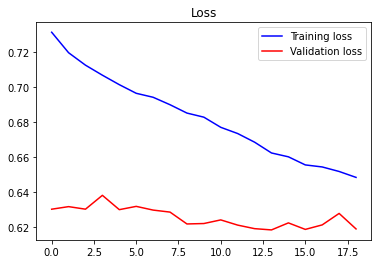

In [ ]:
plot_train_history(multi_step_history, 'Loss')

In [ ]:
pred = multi_step_model.predict(history_train)

In [ ]:
pred = stander.inverse_transform(pred)

In [ ]:
# np.mean(abs(history_train - pred))
pred

array([[5289.763 , 4801.571 , 4723.101 , ..., 4252.808 , 3890.751 ,
        3801.3157],
       [5153.128 , 4901.5317, 4397.7466, ..., 4173.042 , 3938.9912,
        4032.8264],
       [5066.818 , 4859.6226, 4283.211 , ..., 4084.774 , 3858.1216,
        3977.3406],
       ...,
       [3908.4026, 4209.6265, 4061.7412, ..., 3779.0237, 4015.7117,
        4195.193 ],
       [3833.0957, 4141.879 , 4082.325 , ..., 3762.4346, 4025.4902,
        4203.509 ],
       [3772.8083, 4101.656 , 4120.512 , ..., 3881.8384, 4096.6543,
        4174.369 ]], dtype=float32)

### Add more feature to X trian in RNN 

In [ ]:
X, y, stander = pre_process_data_rnn(store_sample)
X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,StateHoliday_a,StateHoliday_b,StateHoliday_c,week_before_StateHoliday_a,week_before_StateHoliday_b,week_before_StateHoliday_c,SchoolHoliday,DayOfWeek,Week,month,year,dayofyear,Sales_std,Sales_mean,Promo,Open,0
Date,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,1,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,-1.958800
2013-01-02,0,0,0,0,0,0,1,0.500000,0.0,0.0,0.0,0.002747,0.000000,0.000000,0,1,0.786505
2013-01-03,0,0,0,0,0,0,1,0.666667,0.0,0.0,0.0,0.005495,3910.300500,2765.000000,0,1,0.189290
2013-01-04,0,0,0,0,0,0,1,0.833333,0.0,0.0,0.0,0.008242,2908.351137,3285.666667,0,1,0.268223
2013-01-05,0,0,0,0,0,0,1,1.000000,0.0,0.0,0.0,0.010989,2449.327306,3585.750000,0,1,0.521903


In [ ]:

start = 0
end = (datetime(2015,4,30) - datetime(2013,1,1)).days
hist_size =  21
targ_size = 8

history_train, target_train = prepare_data(X, y, start, end, hist_size, targ_size)

start = (datetime(2015,4,30) - datetime(2013,1,1)).days + 1
end = start +  (datetime(2015,6,30) - datetime(2015,5,1)).days

history_val, target_val = prepare_data(X, y, start, end, hist_size, targ_size)

In [ ]:

print(f'shape of x train data {history_train.shape}')
print(f'shape of y train data {target_train.shape}')

shape of x train data (820, 21, 17)
shape of y train data (820, 8, 1)


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((history_train, target_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((history_val, target_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [ ]:
tf.keras.utils.set_random_seed(10)
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(21,
                                          return_sequences=True,
                                          input_shape=history_train.shape[-2:]))
 
multi_step_model.add(tf.keras.layers.LSTM(14, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(8))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 21, 21)            3276      
                                                                 
 lstm_4 (LSTM)               (None, 14)                2016      
                                                                 
 dense_1 (Dense)             (None, 8)                 120       
                                                                 
Total params: 5,412
Trainable params: 5,412
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
evaluaion_inter = 30
epochs=30
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data,
                                          epochs=epochs,
                                          steps_per_epoch=evaluaion_inter,
                                          validation_data=val_data,
                                          validation_steps=evaluaion_inter,
                                          callbacks=[early_stopping])

Epoch 1/30
30/30 [==============================] - 6s 59ms/step - loss: 0.7694 - val_loss: 0.6542
Epoch 2/30
30/30 [==============================] - 1s 34ms/step - loss: 0.7301 - val_loss: 0.6491
Epoch 3/30
30/30 [==============================] - 1s 36ms/step - loss: 0.7206 - val_loss: 0.6509
Epoch 4/30
30/30 [==============================] - 1s 35ms/step - loss: 0.7169 - val_loss: 0.6541
Epoch 5/30
30/30 [==============================] - 1s 35ms/step - loss: 0.7147 - val_loss: 0.6578
Epoch 6/30
30/30 [==============================] - 1s 36ms/step - loss: 0.7143 - val_loss: 0.6603
Epoch 7/30
30/30 [==============================] - 1s 38ms/step - loss: 0.7141 - val_loss: 0.6614


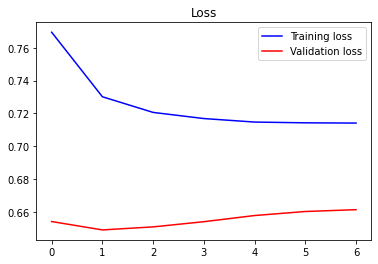

In [ ]:
plot_train_history(multi_step_history, 'Loss')

In [ ]:
abs(y).mean()

0    0.734038
dtype: float64